In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import joblib

In [2]:
#read the file
df = pd.read_csv('src/conversion_data_train.csv')


In [3]:
#see colummns
df.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [4]:
# the new_user columns is not a numerical features, i change the information  '1' by  a 'Y' and '0' by 'N'
df['new_user'] =  df['new_user'].astype(str)
df['new_user'] = [ 'Y' if x == '1' else 'N' for x in df['new_user'] ]

In [5]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ['country','age', 'new_user', 'source', 'total_pages_visited']
target_variable = 'converted'

X = df.loc[:,features_list]
Y = df.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age new_user  source  total_pages_visited
0    China   22        Y  Direct                    2
1       UK   21        Y     Ads                    3
2  Germany   20        N     Seo                   14
3       US   23        Y     Seo                    3
4       US   28        Y  Direct                    3


In [6]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['country', 'new_user', 'source']


C:\Users\dunca\AppData\Local\Temp\ipykernel_5968\2249989688.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,t in X.dtypes.iteritems():


In [7]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [8]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [9]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [10]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
       country  age new_user  source  total_pages_visited
137434   China   19        Y     Seo                    1
112323      US   33        Y  Direct                    5
143261      US   51        Y     Ads                    2
162328   China   17        N     Seo                    1
158039   China   28        Y     Seo                    5
...Done.
[[-1.3990984  -1.15935344  0.          0.          0.          1.
   0.          1.        ]
 [ 0.29299544  0.03743241  0.          0.          1.          1.
   1.          0.        ]
 [ 2.46854467 -0.86015697  0.          0.          1.          1.
   0.          0.        ]
 [-1.64082609 -1.15935344  0.          0.          0.          0.
   0.          1.        ]
 [-0.31132378  0.03743241  0.          0.          0.          1.
   0.          1.        ]]

Performing preprocessings on test set...
       country  age new_user  source  total_pages_visited
138303      UK   34        Y     Ad

In [11]:
# create a dataframe for the score
scores_df = pd.DataFrame(columns = ['model', 'f1-score', 'set'])

In [12]:
# Perform grid search with random forrest classifier
print("Grid search...")
random_forest = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [8],
    'min_samples_leaf': [3],
    'min_samples_split': [2],
    'n_estimators': [90]
}
print(params)
gridsearchRF = GridSearchCV(random_forest, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
gridsearchRF.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearchRF.best_params_)
print("Best validation accuracy : ", gridsearchRF.best_score_)
Y_train_pred = gridsearchRF.predict(X_train)
Y_test_pred = gridsearchRF.predict(X_test)
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
scores_df = scores_df.append({'model': 'random_forest', 'f1-score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'random_forest', 'f1-score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

Grid search...
{'max_depth': [8], 'min_samples_leaf': [3], 'min_samples_split': [2], 'n_estimators': [90]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 90}
Best validation accuracy :  0.9859881228477055
f1-score on training set :  0.7697333434627364
f1-score on test set :  0.7428397318708104


C:\Users\dunca\AppData\Local\Temp\ipykernel_5968\2984160609.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'random_forest', 'f1-score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\dunca\AppData\Local\Temp\ipykernel_5968\2984160609.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'random_forest', 'f1-score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1-score,set
0,random_forest,0.769733,train
1,random_forest,0.742840,test


In [13]:
# perform Bagging with decision tree classifier
print('Training Bagging of decision tree...')
decision_tree = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 1, min_samples_split = 4) # Same hyperparameters as best RF model
bagging = BaggingClassifier(base_estimator=decision_tree, n_estimators = 20)
bagging.fit(X_train, Y_train)
print("...Done.")
Y_train_pred = bagging.predict(X_train)
Y_test_pred = bagging.predict(X_test)
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
scores_df = scores_df.append({'model': 'bagging_dt', 'f1-score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'bagging_dt', 'f1-score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

Training Bagging of decision tree...
...Done.
f1-score on training set :  0.7731533558305211
f1-score on test set :  0.744297719087635


C:\Users\dunca\AppData\Local\Temp\ipykernel_5968\1521715860.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'bagging_dt', 'f1-score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\dunca\AppData\Local\Temp\ipykernel_5968\1521715860.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'bagging_dt', 'f1-score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1-score,set
0,random_forest,0.769733,train
1,random_forest,0.742840,test
2,bagging_dt,0.773153,train
3,bagging_dt,0.744298,test


In [14]:

# perform XGBoost classifier
print('Training XGBClassifier...')
XGBoost = XGBClassifier()
XGBoost.fit(X_train, Y_train)
print("...Done.")
Y_train_pred = XGBoost.predict(X_train)
Y_test_pred = XGBoost.predict(X_test)
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
scores_df = scores_df.append({'model': 'XGBoost', 'f1-score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'XGBoost', 'f1-score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

Training XGBClassifier...
...Done.
f1-score on training set :  0.7772533153517645
f1-score on test set :  0.7491778774289984


C:\Users\dunca\AppData\Local\Temp\ipykernel_5968\2598887916.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'XGBoost', 'f1-score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\dunca\AppData\Local\Temp\ipykernel_5968\2598887916.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'XGBoost', 'f1-score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1-score,set
0,random_forest,0.769733,train
1,random_forest,0.742840,test
2,bagging_dt,0.773153,train
3,bagging_dt,0.744298,test
4,XGBoost,0.777253,train
5,XGBoost,0.749178,test


In [15]:
# Perform grid search with AdaBoost classifier on Logistic regression
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000)
adaboost_logreg = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C':  [5.0],
    'n_estimators': [60]
}
print(params)
gridsearchADA_LR = GridSearchCV(adaboost_logreg, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
gridsearchADA_LR.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearchADA_LR.best_params_)
print("Best validation accuracy : ", gridsearchADA_LR.best_score_)
Y_train_pred = gridsearchADA_LR.predict(X_train)
Y_test_pred = gridsearchADA_LR.predict(X_test)
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
scores_df = scores_df.append({'model': 'adaboost_logreg', 'f1-score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'adaboost_logreg', 'f1-score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

Grid search...
{'base_estimator__C': [5.0], 'n_estimators': [60]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
...Done.
Best hyperparameters :  {'base_estimator__C': 5.0, 'n_estimators': 60}
Best validation accuracy :  0.9862824161922834
f1-score on training set :  0.7655250282273239
f1-score on test set :  0.7533875338753387


C:\Users\dunca\AppData\Local\Temp\ipykernel_5968\1073700097.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'adaboost_logreg', 'f1-score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\dunca\AppData\Local\Temp\ipykernel_5968\1073700097.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'adaboost_logreg', 'f1-score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1-score,set
0,random_forest,0.769733,train
1,random_forest,0.742840,test
2,bagging_dt,0.773153,train
3,bagging_dt,0.744298,test
4,XGBoost,0.777253,train
5,XGBoost,0.749178,test
6,adaboost_logreg,0.765525,train
7,adaboost_logreg,0.753388,test


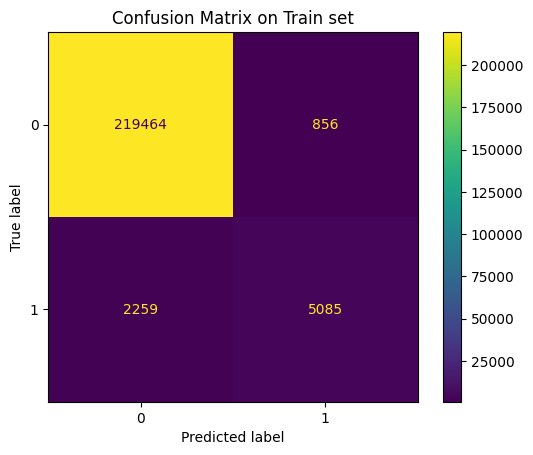

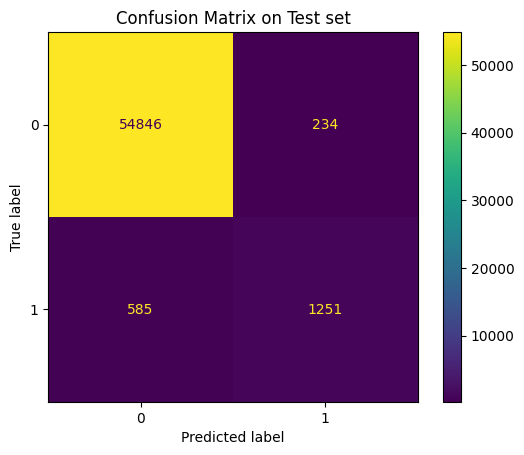

In [16]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearchADA_LR, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearchADA_LR, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [17]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

gridsearchADA_LR.fit(X,Y)

Y_pred = gridsearchADA_LR.predict(X)
print("f1-score on all set : ", f1_score(Y, Y_pred))


Fitting 3 folds for each of 1 candidates, totalling 3 fits
f1-score on all set :  0.7629848585389396


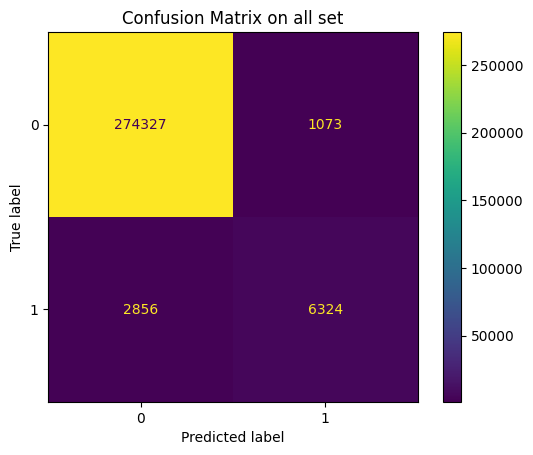

In [18]:
# confusion matrix on all train file
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on all set") # Set a title that we will add into ConfusionMatrixDisplay
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')

ConfusionMatrixDisplay.from_estimator(gridsearchADA_LR, X, Y, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [19]:
#save the best model
joblib.dump(gridsearchADA_LR.best_estimator_, "src/model.joblib", compress=3)

['src/model.joblib']